# Demand forecasting with the Temporal Fusion Transformer


Our example is a demand forecast from the [Stallion kaggle competition](https://www.kaggle.com/utathya/future-volume-prediction).


In [3]:
# 导入 warnings 模块，用于控制 Python 警告的显示行为
import warnings
# 忽略所有警告信息，避免在输出中打印绝对路径等不必要的信息
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [5]:
# 导入 copy 模块，提供对 Python 对象进行浅拷贝和深拷贝的功能
import copy

# 从 pathlib 模块中导入 Path 类，用于跨平台的文件与目录路径操作
from pathlib import Path

# 导入 warnings 模块，用于控制和过滤运行时发出的警告信息
import warnings

# 导入 Lightning 的 PyTorch 接口，简化训练循环、分布式训练等操作
import lightning.pytorch as pl

# 导入 Lightning 回调：EarlyStopping（早停）用于在验证指标不再提升时停止训练，
# LearningRateMonitor（学习率监控）用于记录训练过程中学习率的变化
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor

# 导入 TensorBoardLogger，用于将训练日志写入 TensorBoard 以便可视化
from lightning.pytorch.loggers import TensorBoardLogger

# 导入 NumPy 和 Pandas，分别用于高效的数值计算和表格数据处理
import numpy as np
import pandas as pd

# 导入 PyTorch，进行张量运算和深度学习模型定义
import torch

# 从 pytorch_forecasting 包导入：
# Baseline：基准模型，用于快速评估最简单的预测效果；
# TemporalFusionTransformer：时序融合变换器模型，可捕捉复杂时序关系；
# TimeSeriesDataSet：封装时间序列数据的工具类，方便批量化训练
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet

# 导入 GroupNormalizer，用于对不同行进行分组归一化，适应指标量纲差异
from pytorch_forecasting.data import GroupNormalizer

# 导入多种评价指标和损失函数：
# MAE：平均绝对误差；SMAPE：对称平均百分比误差；
# PoissonLoss：泊松分布假设下的损失；QuantileLoss：分位数回归损失
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

# 导入时序融合变换器的自动调参函数，用于搜索最优超参数组合
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

## Load data


First, we need to transform our time series into a pandas dataframe where each row can be identified with a time step and a time series. Fortunately, most datasets are already in this format. For this tutorial, we will use the [Stallion dataset from Kaggle](https://www.kaggle.com/utathya/future-volume-prediction) describing sales of various beverages. Our task is to make a six-month forecast of the sold volume by stock keeping units (SKU), that is products, sold by an agency, that is a store. There are about 21 000 monthly historic sales records. In addition to historic sales we have information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry.

The dataset is already in the correct format but misses some important features. Most importantly, we need to add a time index that is incremented by one for each time step. Further, it is beneficial to add date features, which in this case means extracting the month from the date record.


In [6]:
# 从示例模块中导入获取 stallion 数据集的函数
from pytorch_forecasting.data.examples import get_stallion_data

# 调用函数加载数据，返回一个包含日期、销量、SKU、代理商等信息的 DataFrame
data = get_stallion_data()

# —— 构造时间索引 ——
# 将日期拆分为年和月，并转换为一个单调递增的整数指标 time_idx
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
# 将索引基准化，使最小值从 0 开始
data["time_idx"] -= data["time_idx"].min()

# —— 添加额外特征 ——
# 月份特征：将 month 列转换为字符串类别，以便于后续的 embedding 或 one-hot 编码
data["month"] = data.date.dt.month.astype(str).astype("category")

# 对销量取对数，缓解长尾分布带来的数值偏差（加上极小值防止 log(0)）
data["log_volume"] = np.log(data.volume + 1e-8)

# 按照每个 time_idx 和 sku 计算当月平均销量，作为 SKU 级别的全局趋势特征
data["avg_volume_by_sku"] = data.groupby(
    ["time_idx", "sku"], observed=True
).volume.transform("mean")

# 按照每个 time_idx 和 agency 计算当月平均销量，作为代理商级别的全局趋势特征
data["avg_volume_by_agency"] = data.groupby(
    ["time_idx", "agency"], observed=True
).volume.transform("mean")

# —— 还原特殊节假日的独热编码并合并为一个类别特征 ——
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
# 对每个节假日列，将 0 映射为 "-"（无该节日），1 映射为节日名称，
# 最终转成 category 类型以供模型处理
data[special_days] = (
    data[special_days]
      .apply(lambda x: x.map({0: "-", 1: x.name}))
      .astype("category")
)

# 随机抽样 10 行数据进行预览，设置 random_state 保证结果可复现
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [4]:
data.describe()

,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,21000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,2015-06-16 20:48:00,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
min,0.000000,2013-01-01 00:00:00,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,2014-03-24 06:00:00,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,2015-06-16 00:00:00,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,2016-09-08 12:00:00,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,2017-12-01 00:00:00,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375
std,2711.496882,NaN,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698


### Create dataset and dataloaders


In [29]:
# 设置预测长度、编码长度和训练截止点
max_prediction_length = 6  # 最大预测步长：模型一次预测未来 6 个月数据
max_encoder_length = 24    # 最大编码器步长：模型观察历史 24 个月数据
training_cutoff = data["time_idx"].max() - max_prediction_length  
# 留出最后 6 个月的数据作为验证集

# 构造训练用 TimeSeriesDataSet
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],  # 仅使用截止点前的数据进行训练
    time_idx="time_idx",                             # 时间序列索引列
    target="volume",                                 # 预测目标：销量
    group_ids=["agency", "sku"],                     # 每个 agency–sku 组合视为一条独立序列
    min_encoder_length=max_encoder_length,           # 编码器最小长度（保持定长）
    max_encoder_length=max_encoder_length,           # 编码器最大长度
    min_prediction_length=1,                         # 最小预测步长至少 1
    max_prediction_length=max_prediction_length,     # 最大预测步长
    static_categoricals=["agency", "sku"],           # 不随时间变化的类别特征
    static_reals=["avg_population_2017",              # 不随时间变化的数值特征
                  "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],  
    # 编码器和解码器都已知的类别特征
    variable_groups={"special_days": special_days},             
    # 将所有节假日列合并为同一组特征
    time_varying_known_reals=["time_idx", "price_regular",      
                               "discount_in_percent"],  
    # 编码器和解码器都已知的数值特征
    time_varying_unknown_categoricals=[],                       
    # 解码器未知的类别特征（此处无）
    time_varying_unknown_reals=[                               
        "volume",           # 需要预测的销量
        "log_volume",       # 对数销量
        "industry_volume",  # 行业总销量
        "soda_volume",      # 碳酸饮料销量
        "avg_max_temp",     # 当月平均最高气温
        "avg_volume_by_agency",  # 代理商月平均销量
        "avg_volume_by_sku",     # SKU 月平均销量
    ],
    target_normalizer=GroupNormalizer(    
        groups=["agency", "sku"], transformation="softplus"
    ),  # 分组归一化：按 agency 和 sku 对目标做 softplus 转换并归一化
    add_relative_time_idx=True,  # 添加相对时间索引（0 到 encoder 长度-1）
    add_target_scales=True,      # 将目标的归一化比例因子加入到模型输入
    add_encoder_length=True,     # 添加实际编码器长度到模型输入
)

# 构造验证集：预测每条序列的最后 max_prediction_length 步
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,            # 解码器输入使用最后 max_prediction_length 步
    stop_randomization=True  # 停止随机打乱，保证验证结果可复现
)

# 创建 PyTorch DataLoader 供模型训练和验证使用
batch_size = 128  # 批量大小，一般取值在 32 到 128 之间
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)  # 训练 DataLoader
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)  # 验证 DataLoader，批量增大以加速评估

## Create baseline model


In [30]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# 使用 Baseline 基准模型进行预测：对每个序列，下一步预测值设为该序列历史中的最后一个观测值
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)

# 计算平均绝对误差（MAE）：衡量基准预测（baseline_predictions.output）与真实值（baseline_predictions.y）之间的平均绝对差
MAE()(baseline_predictions.output, baseline_predictions.y)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(293.0089, device='mps:0')

## Train the Temporal Fusion Transformer


### Find optimal learning rate


Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).


In [32]:
# 设置随机种子以保证实验结果可复现
pl.seed_everything(42)

# 配置 PyTorch Lightning 的 Trainer
trainer = pl.Trainer(
    accelerator="cpu",          # 指定在 CPU 上训练，可改为 "gpu" 或自动识别
    gradient_clip_val=0.1,      # 梯度裁剪阈值，防止 RNN/注意力模型中的梯度爆炸
)

# 基于前面创建的 TimeSeriesDataSet 构建 TemporalFusionTransformer 模型
tft = TemporalFusionTransformer.from_dataset(
    training,                   # 输入训练集数据集
    learning_rate=0.03,         # 学习率：训练中最关键的超参数之一
    hidden_size=8,              # 隐层维度大小，控制模型容量
    attention_head_size=1,      # 注意力头数量，数据集大时可设置到 4
    dropout=0.1,                # Dropout 比例，0.1–0.3 范围常用
    hidden_continuous_size=8,   # 连续特征隐层大小，需小于等于 hidden_size
    loss=QuantileLoss(),        # 使用分位数损失函数，适合预测区间估计
    optimizer="ranger",         # Ranger 优化器（结合 RAdam + Lookahead）
    # reduce_on_plateau_patience=1000,  # 如果验证损失长时间不下降，可启用学习率调度
)

# 打印模型参数总量（单位：千），便于评估模型复杂度
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.5k


Finding best initial lr: 100%|██████████| 100/100 [00:06<00:00, 15.92it/s]
Learning rate set to 1.8197008586099834e-05
Restoring states from the checkpoint path at /Users/tiger/workspace/project/pytorch-forecasting/docs/source/tutorials/.lr_find_e9fef9d8-0c4b-48a0-8369-633f9bfb11fd.ckpt
Restored all states from the checkpoint at /Users/tiger/workspace/project/pytorch-forecasting/docs/source/tutorials/.lr_find_e9fef9d8-0c4b-48a0-8369-633f9bfb11fd.ckpt


suggested learning rate: 1.8197008586099834e-05


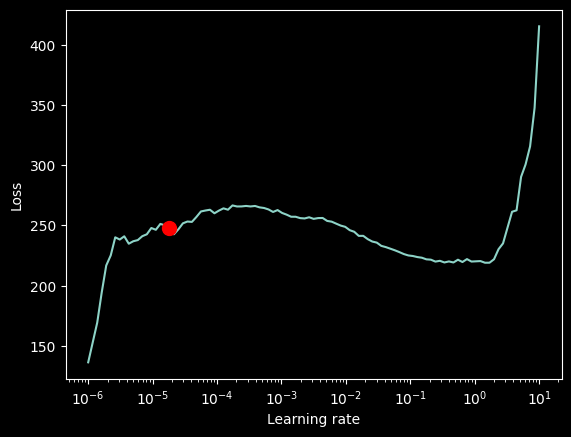

In [33]:
# 导入 Lightning Tuner，用来自动搜索模型的最佳学习率
from lightning.pytorch.tuner import Tuner

# 使用 lr_find 工具在指定的学习率范围内测试训练和验证损失
# train_dataloaders：训练数据加载器
# val_dataloaders：验证数据加载器
# min_lr 和 max_lr 定义了搜索的学习率范围
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-6,
    max_lr=10.0,
)

# 打印出 lr_find 建议的最优学习率
print(f"suggested learning rate: {res.suggestion()}")

# 绘制学习率与损失的曲线图，并在图上标出建议的学习率
fig = res.plot(show=True, suggest=True)
# 在 Jupyter/Notebook 环境中显示该图
fig.show()

### Train model


If you have troubles training the model and get an error `AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'`, consider either uninstalling tensorflow or first execute

````
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
```.
````


In [34]:
# 配置早停回调：当验证集损失（val_loss）在 patience 次迭代内未降低时，提前停止训练
early_stop_callback = EarlyStopping(
    monitor="val_loss",    # 监控的指标名称
    min_delta=1e-4,        # 最小变化量，只有超过该值才计作“改进”
    patience=10,           # 容忍的连续无改进 epoch 数
    verbose=False,         # 是否打印早停信息
    mode="min"             # “min” 模式：当监控指标停止降低时触发
)

# 配置学习率监控回调：记录训练过程中的学习率变化，方便后续分析
lr_logger = LearningRateMonitor()

# 配置 TensorBoard 日志：将训练指标和超参数记录到指定目录，可在 TensorBoard 中查看
logger = TensorBoardLogger("lightning_logs")

# 实例化 PyTorch Lightning Trainer，设置训练流程和回调
trainer = pl.Trainer(
    max_epochs=20,               # 最多训练 20 个 epoch
    accelerator="cpu",           # 在 CPU 上训练，可改为 "gpu" 以使用 GPU
    enable_model_summary=True,   # 在训练开始时打印模型结构和参数统计
    gradient_clip_val=0.1,       # 梯度裁剪阈值，防止梯度爆炸
    limit_train_batches=50,      # 每个 epoch 仅跑 50 个训练批次，用于快速调试
    # fast_dev_run=True,         # 快速开发模式：只跑一个训练和验证批次，检查代码是否有错误
    callbacks=[lr_logger, early_stop_callback],  # 添加学习率监控和早停回调
    logger=logger                # 使用 TensorBoardLogger 记录训练日志
)

# 基于训练集构建 TemporalFusionTransformer 模型，设置核心超参数
tft = TemporalFusionTransformer.from_dataset(
    training,                   # 训练数据集（TimeSeriesDataSet）
    learning_rate=0.03,         # 初始学习率
    hidden_size=16,             # 隐藏状态向量的维度
    attention_head_size=2,      # 多头注意力中的头数量
    dropout=0.1,                # Dropout 比例，用于缓解过拟合
    hidden_continuous_size=8,   # 连续特征在网络中的隐藏维度
    loss=QuantileLoss(),        # 分位数损失函数，适合预测区间估计
    log_interval=10,            # 每隔 10 个批次记录一次日志
    optimizer="ranger",         # 使用 Ranger 优化器（结合 RAdam 和 Lookahead）
    reduce_on_plateau_patience=4,# 当验证损失在 4 次评估后无改进时，自动降低学习率
)

# 打印模型参数总数（单位：千），帮助评估模型复杂度
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.4k


Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.


In [35]:
# 启动训练过程：在训练集上优化模型，并在验证集上评估性能
trainer.fit(
    tft,                          # 要训练的 TemporalFusionTransformer 模型
    train_dataloaders=train_dataloader,  # 提供训练数据的 DataLoader
    val_dataloaders=val_dataloader       # 提供验证数据的 DataLoader，用于每个 epoch 后评估
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Epoch 19: 100%|██████████| 50/50 [00:04<00:00, 12.11it/s, v_num=1, train_loss_step=107.0, val_loss=200.0, train_loss_epoch=143.0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 50/50 [00:04<00:00, 11.93it/s, v_num=1, train_loss_step=107.0, val_loss=200.0, train_loss_epoch=143.0]


### Hyperparameter tuning


## Evaluate performance


PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.


In [11]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [12]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
MAE()(predictions.output, predictions.y)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(359.3375)

In [13]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


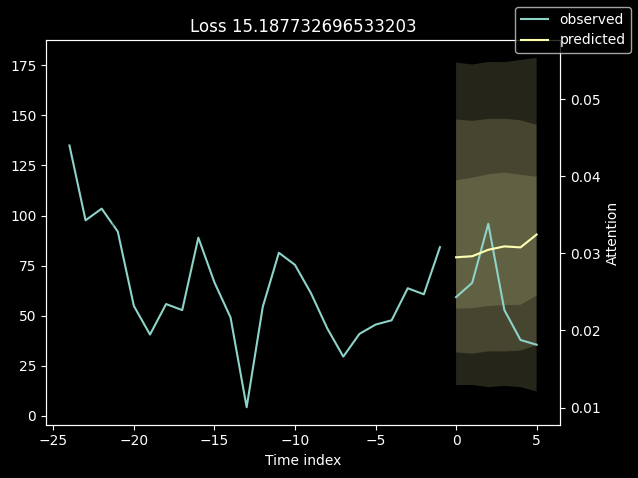

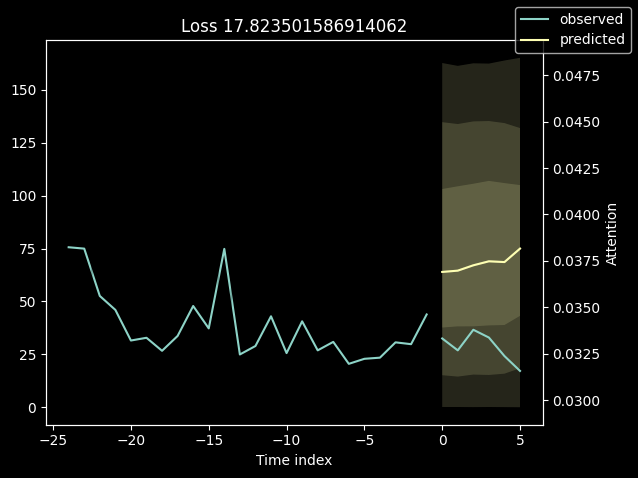

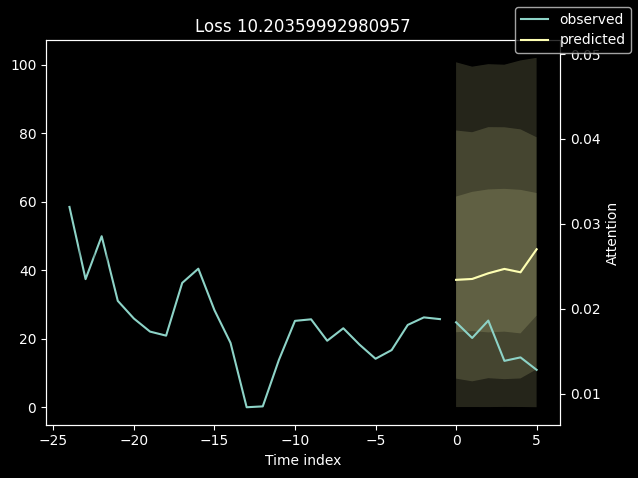

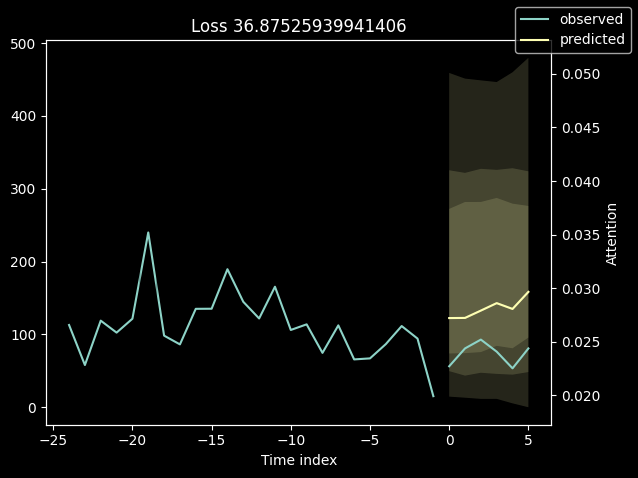

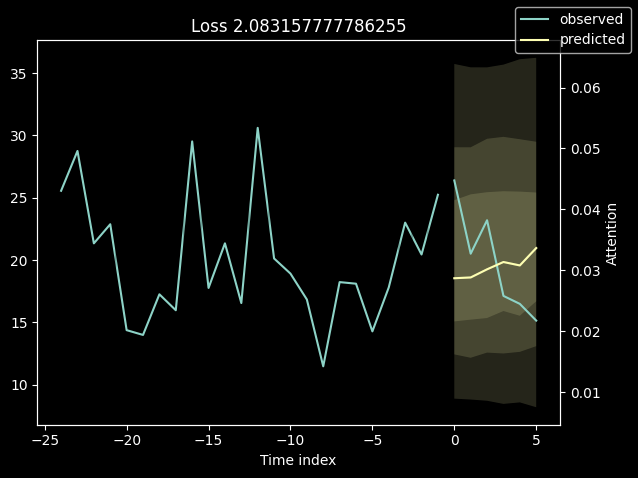

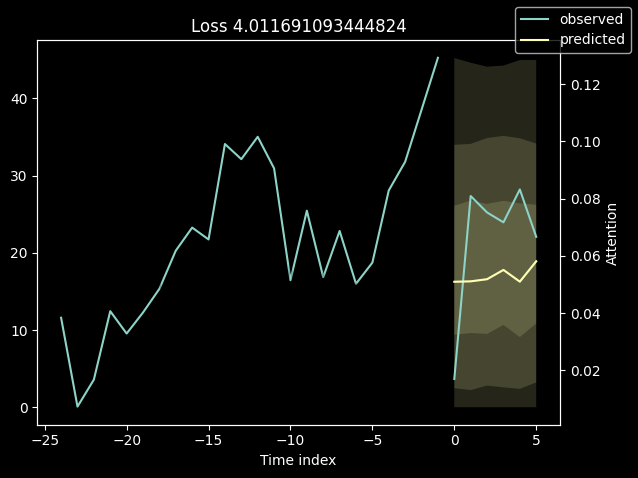

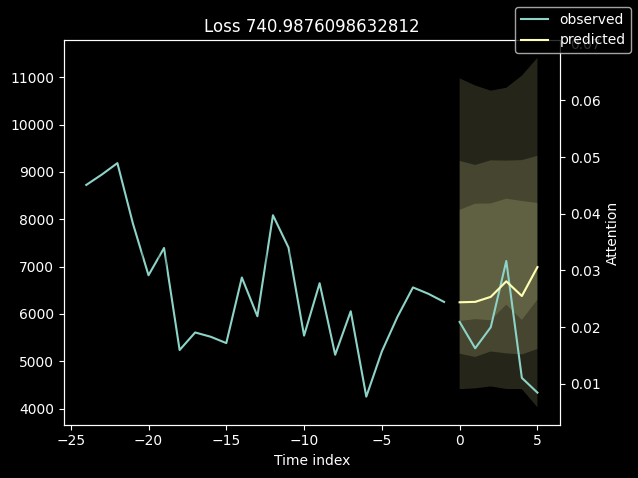

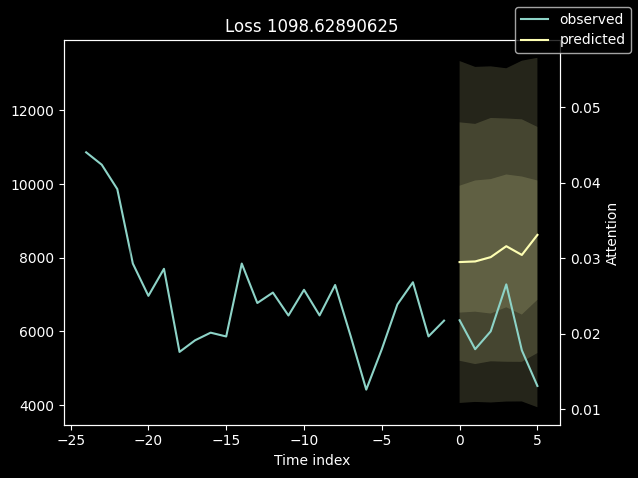

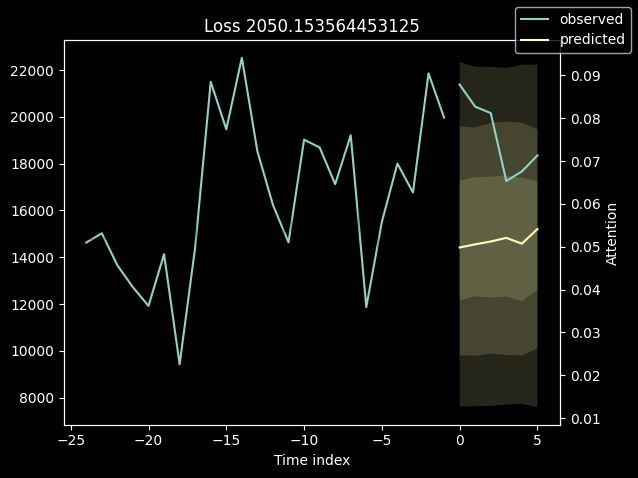

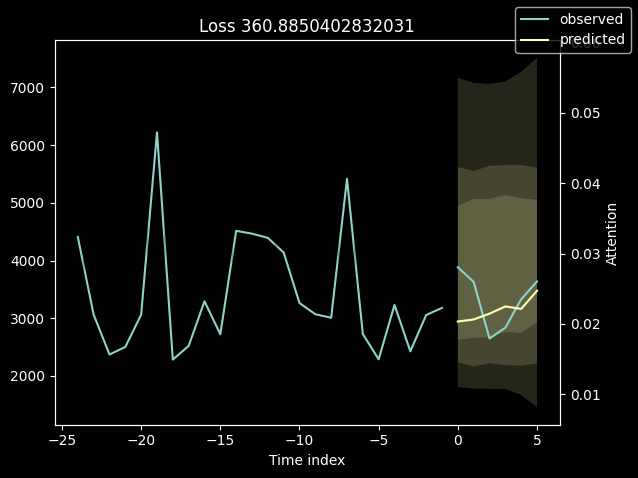

In [14]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

### Worst performers


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


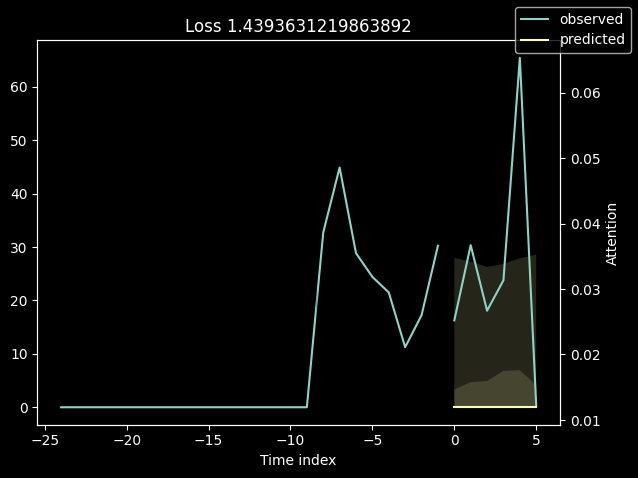

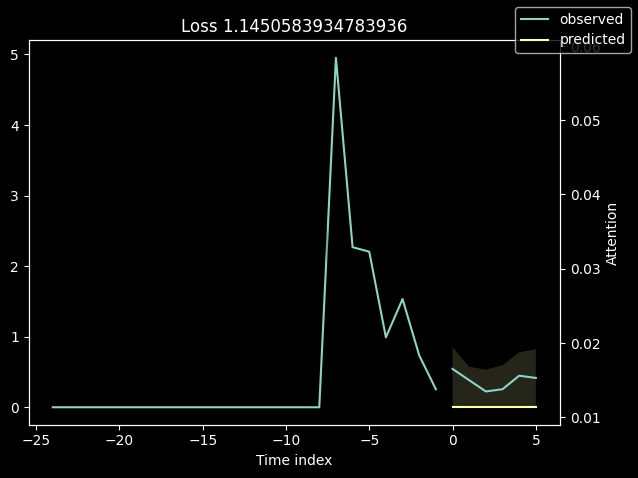

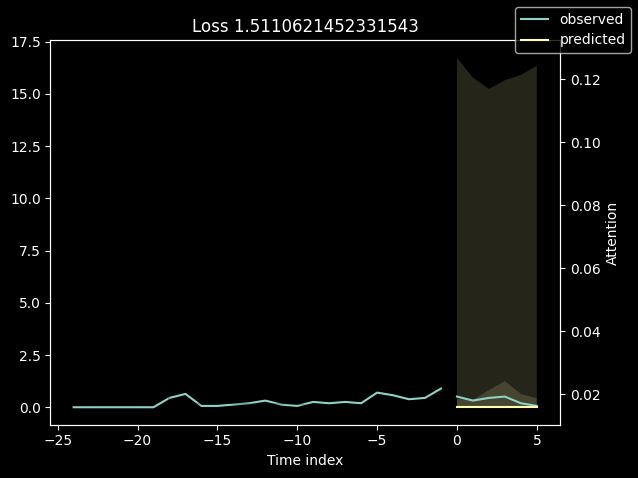

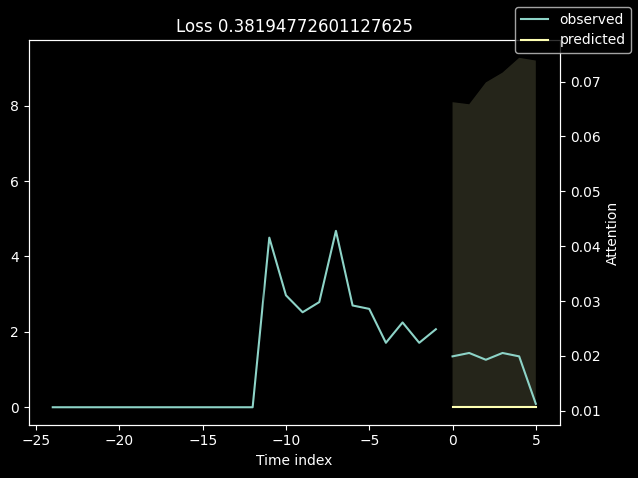

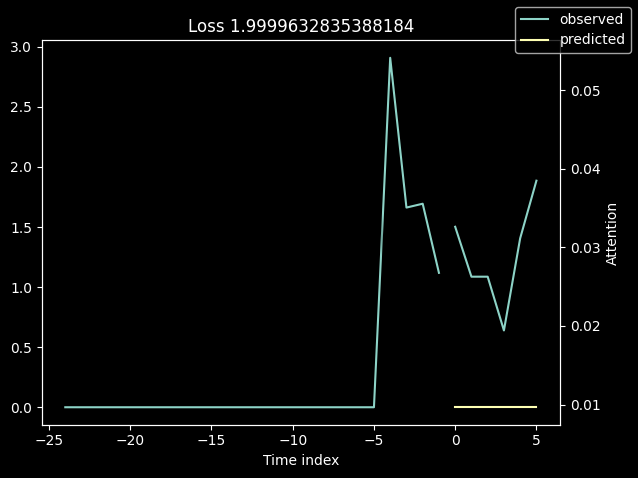

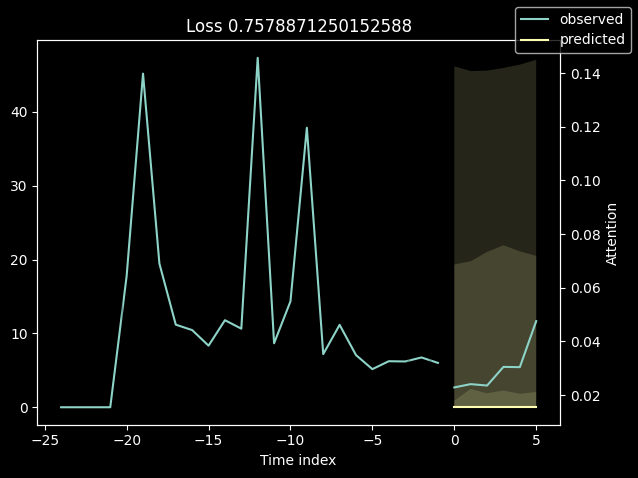

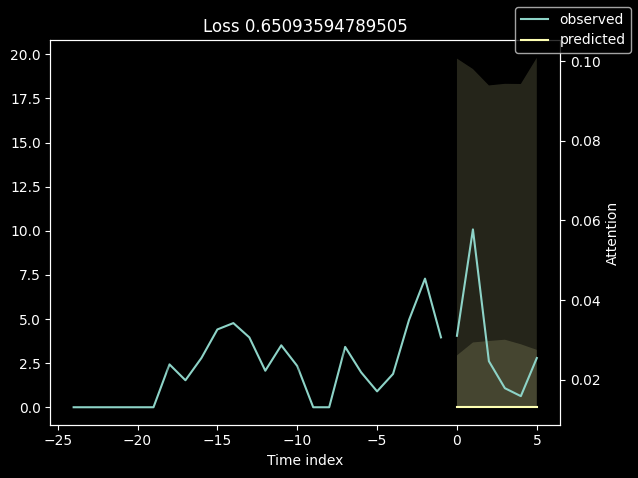

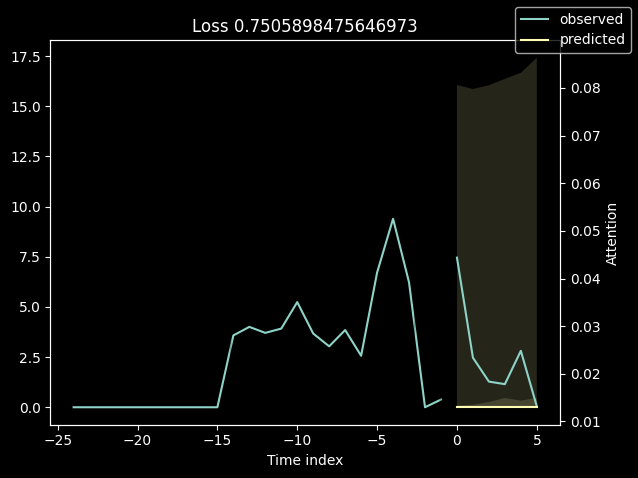

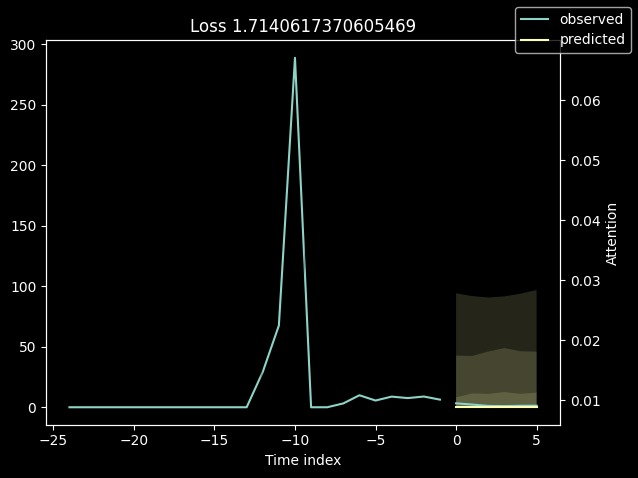

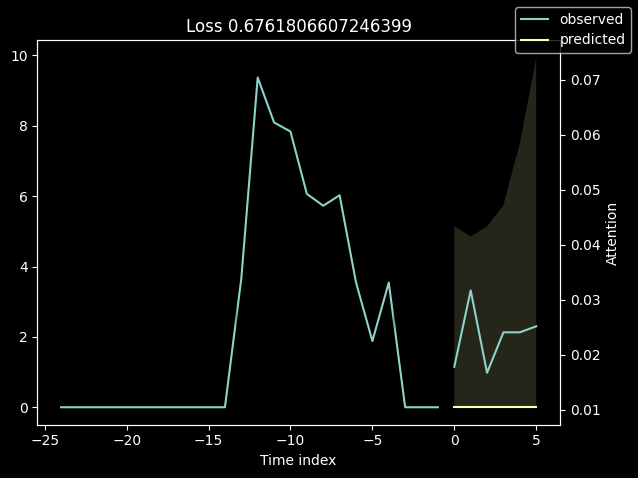

In [15]:
# calcualte metric by which to display
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
mean_losses = SMAPE(reduction="none").loss(predictions.output, predictions.y[0]).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

### Actuals vs predictions by variables


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'avg_population_2017': <Figure size 1000x500 with 2 Axes>,
 'avg_yearly_household_income_2017': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'volume_center': <Figure size 1000x500 with 2 Axes>,
 'volume_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'price_regular': <Figure size 1000x500 with 2 Axes>,
 'discount_in_percent': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'volume': <Figure size 1000x500 with 2 Axes>,
 'log_volume': <Figure size 1000x500 with 2 Axes>,
 'industry_volume': <Figure size 1000x500 with 2 Axes>,
 'soda_volume': <Figure size 1000x500 with 2 Axes>,
 'avg_max_temp': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_agency': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_sku': <Figure size 1000x500 with 2 Axes>,
 'agency': <Figure size 1000x500 with 2 Axes>,
 'sku': <Figure size 1000x500 with 2 Axes>,
 'special_days'

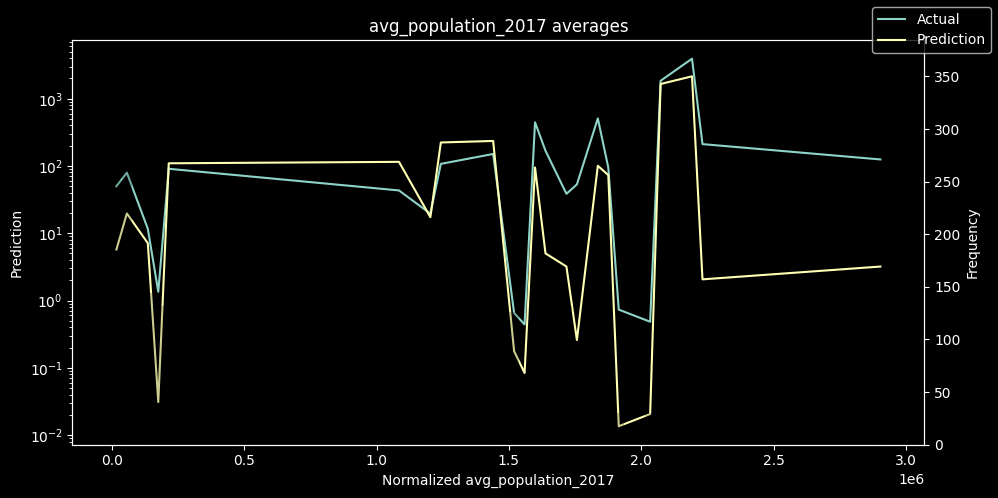

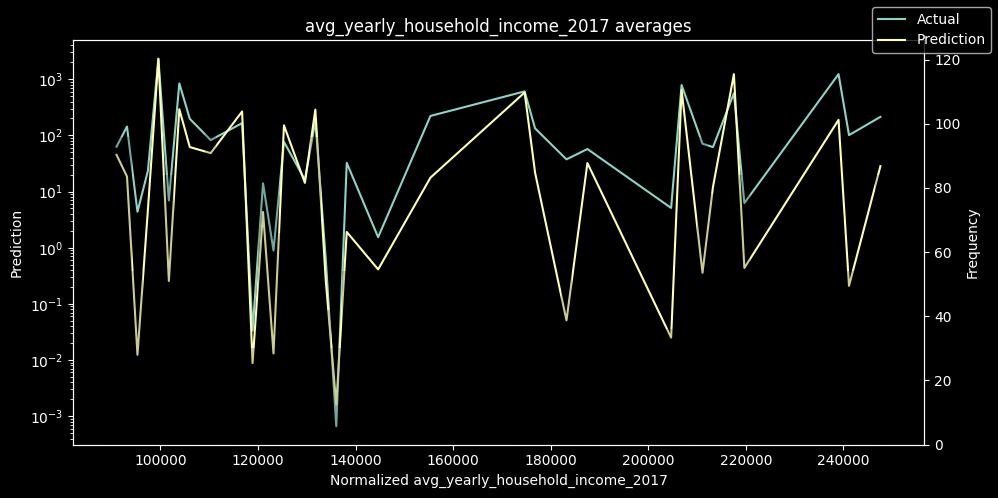

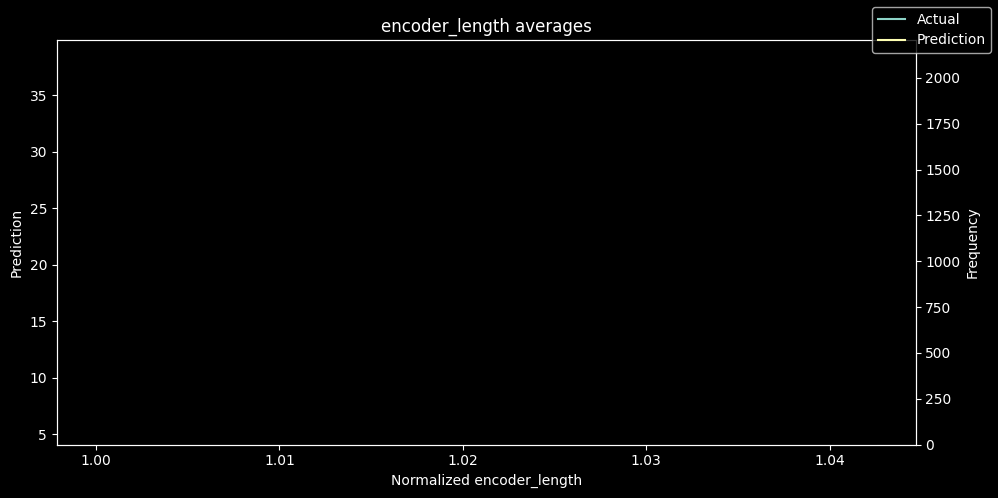

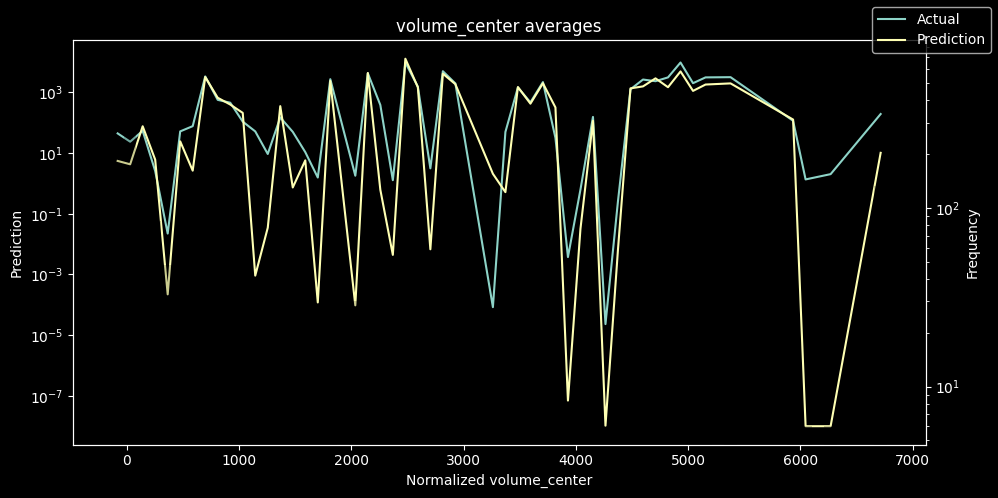

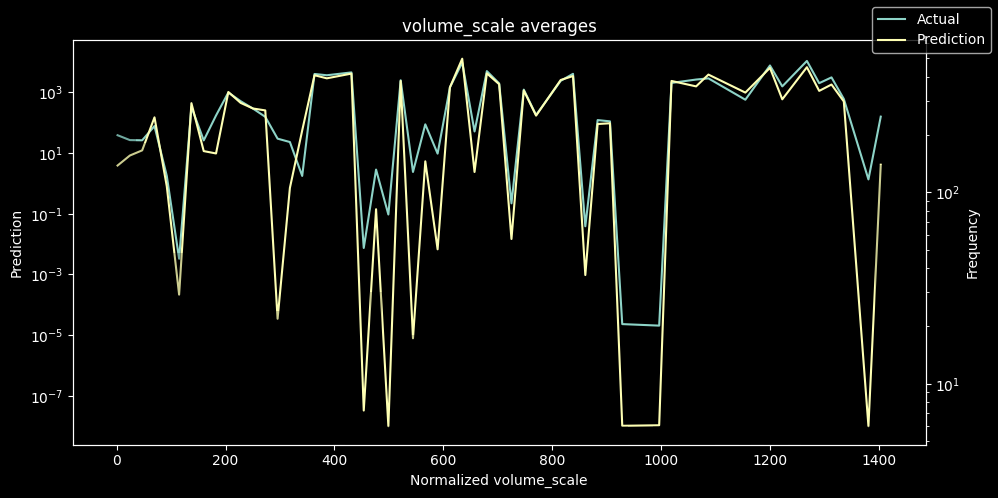

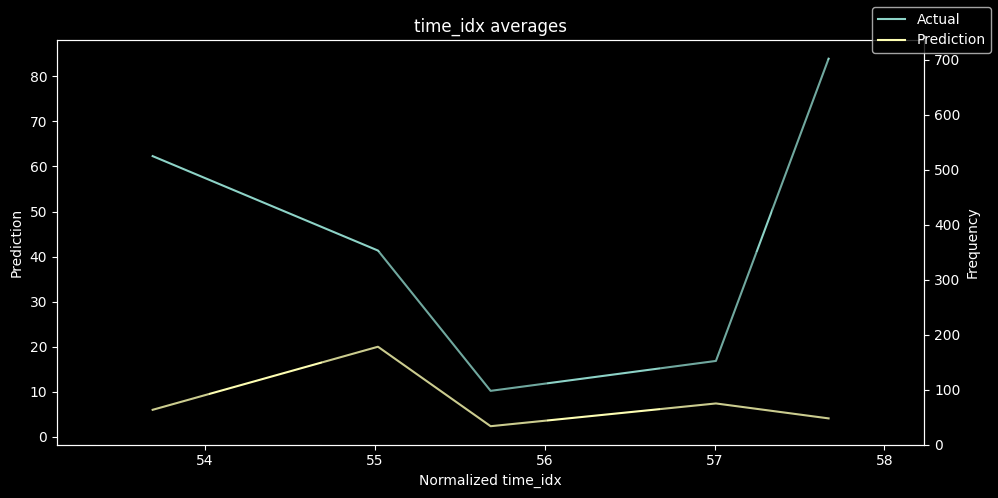

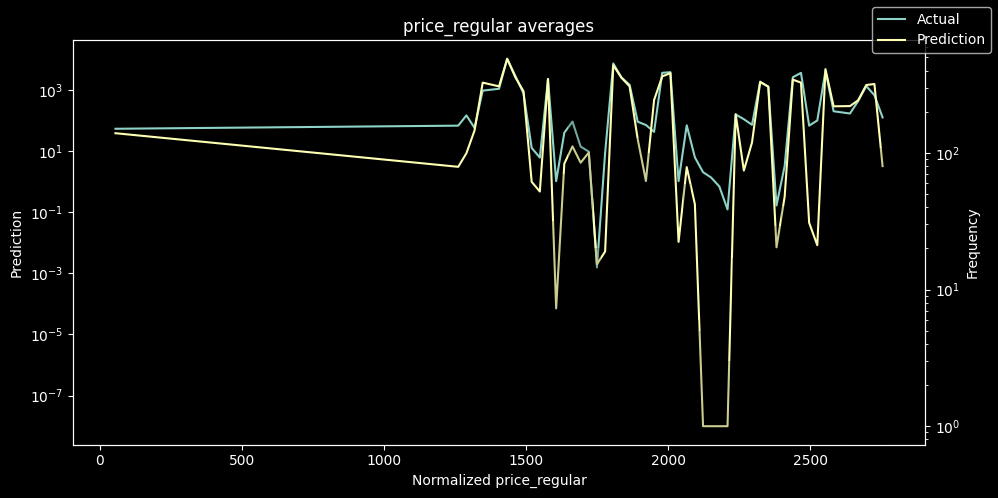

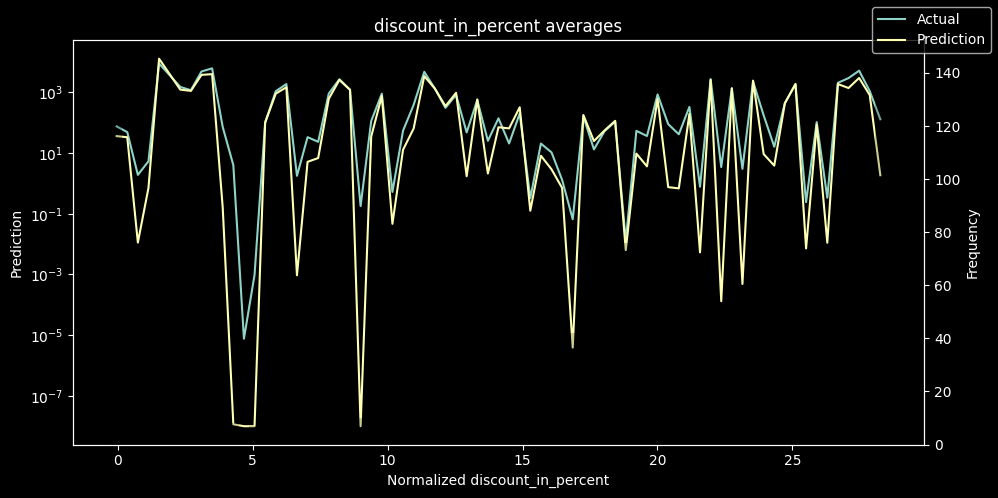

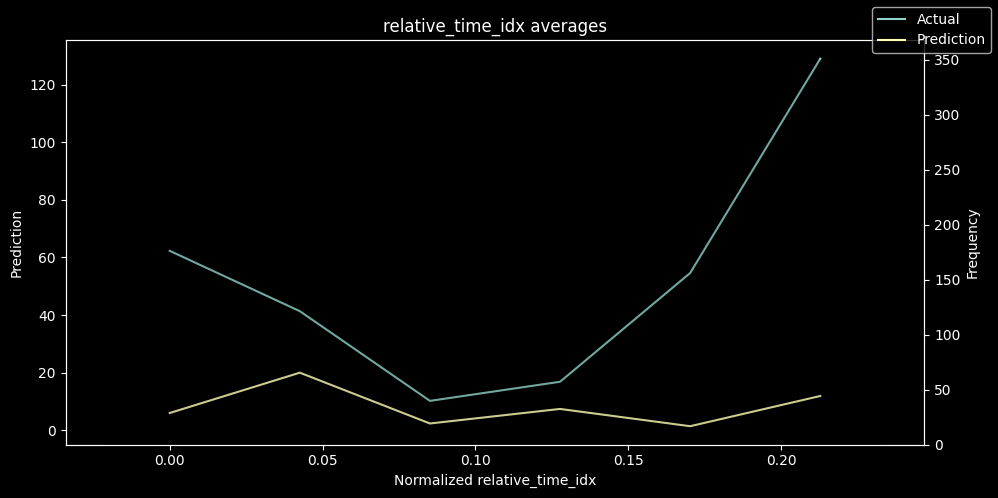

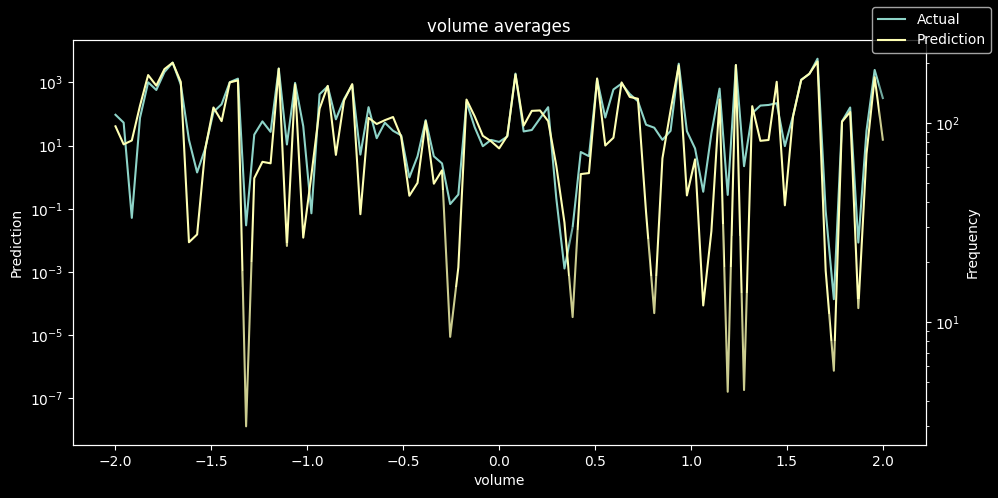

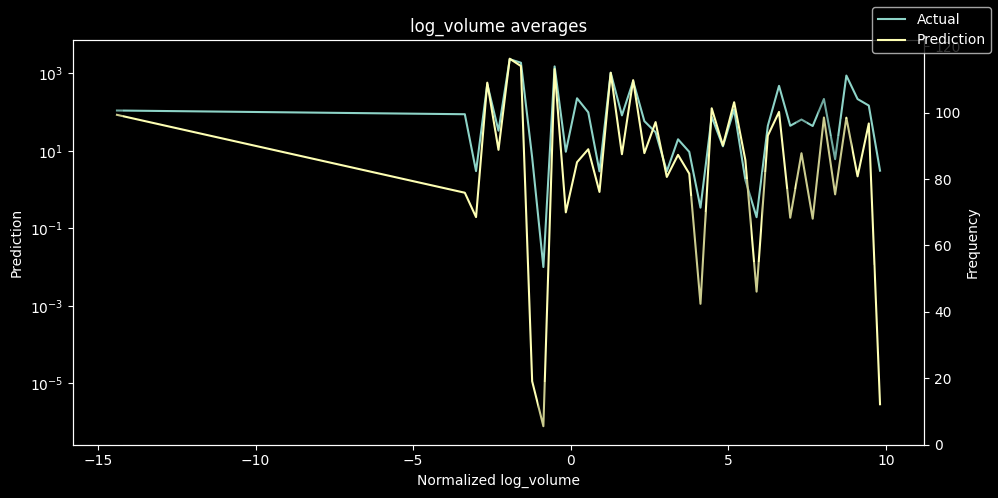

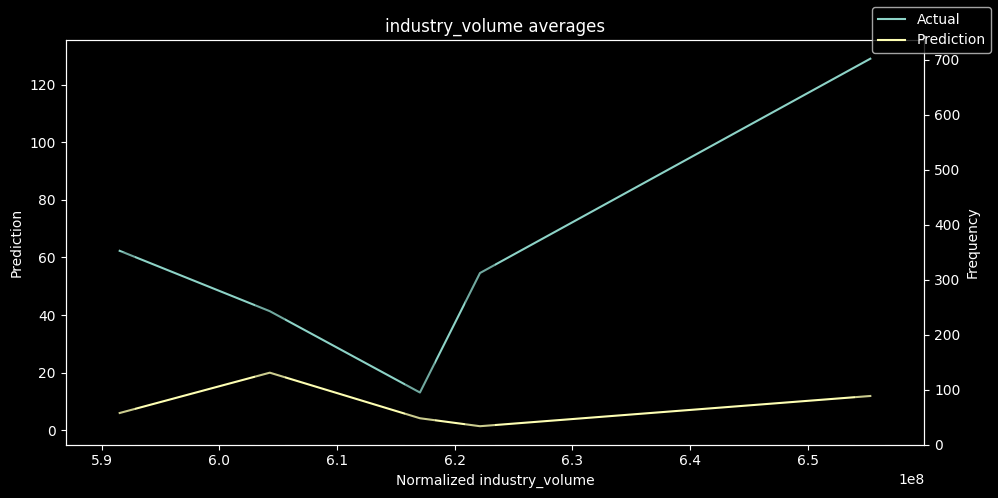

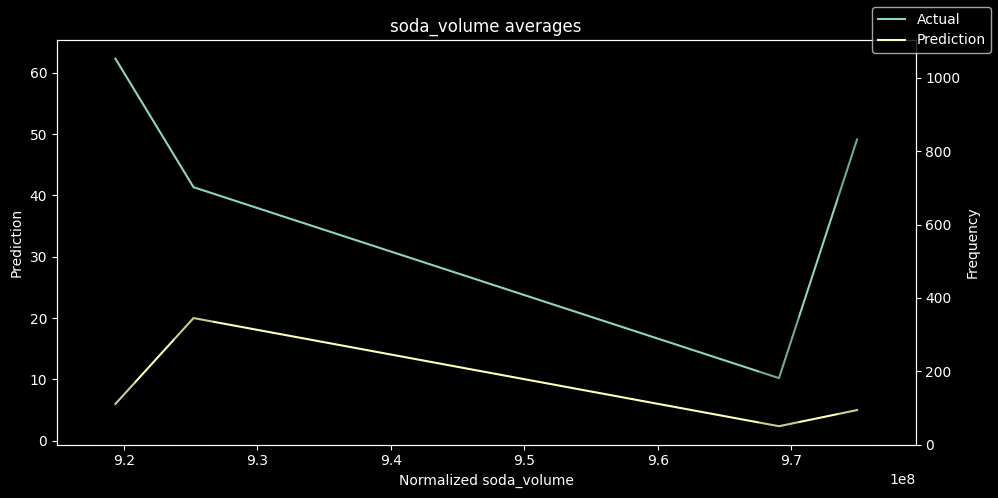

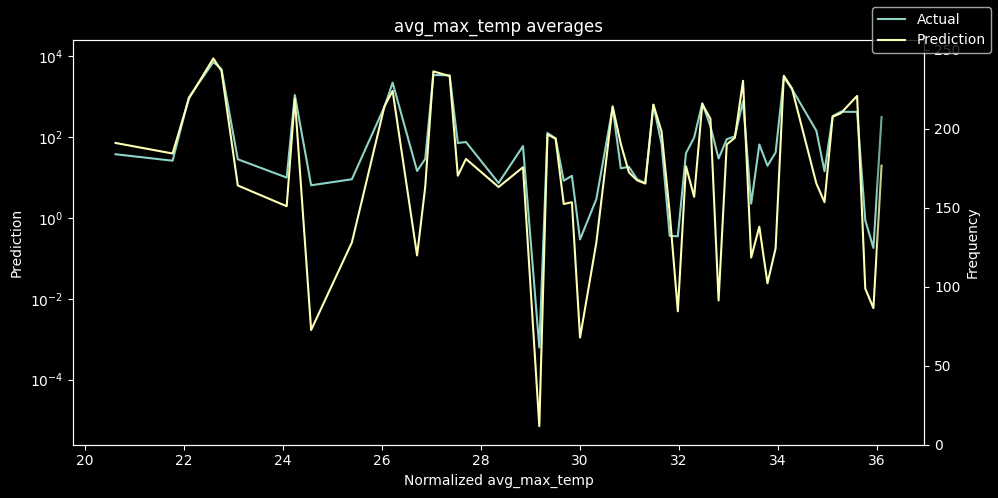

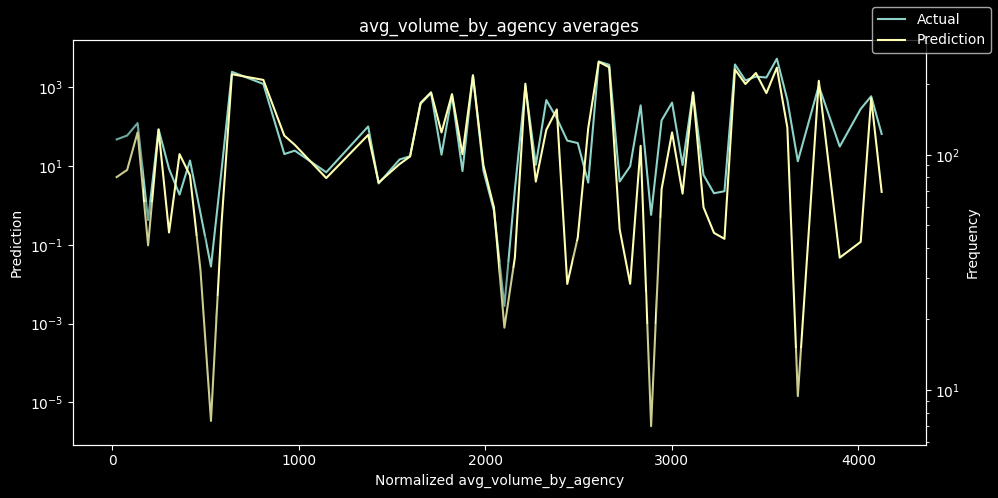

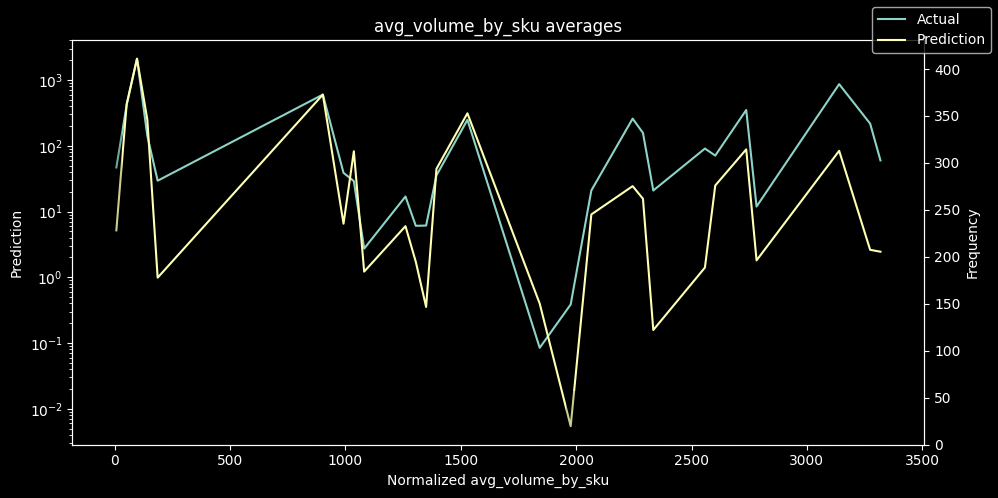

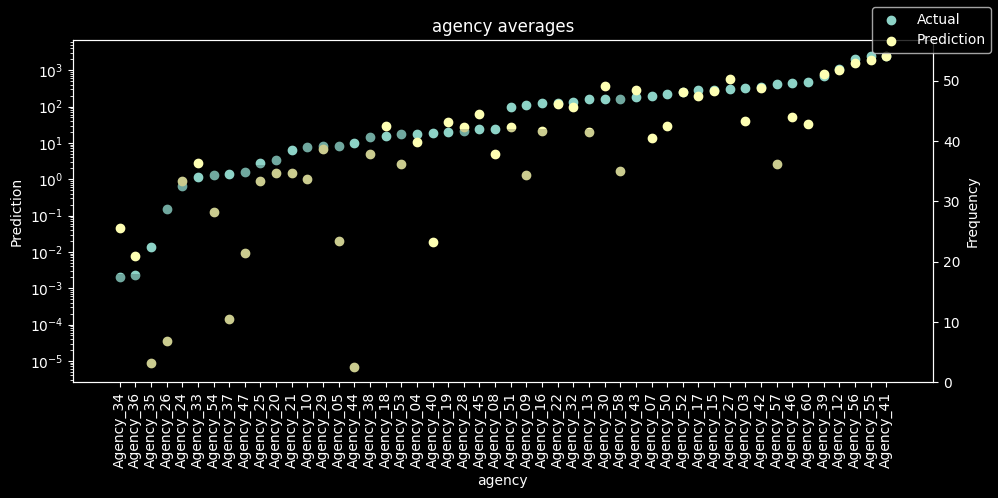

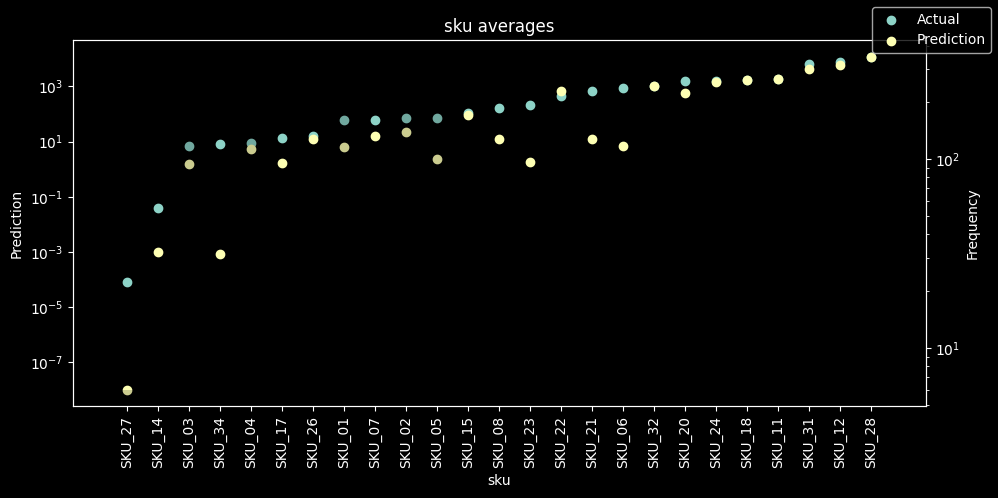

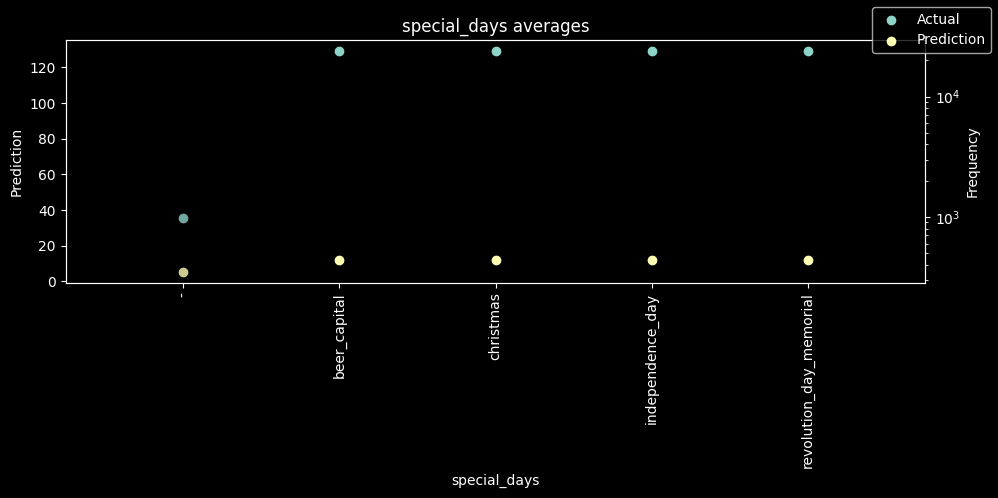

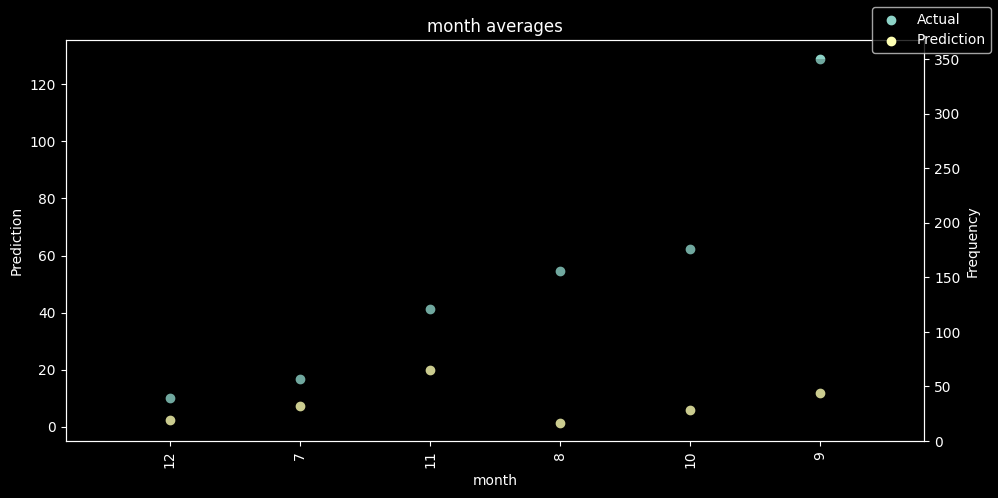

In [16]:
predictions = best_tft.predict(
    val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

## Predict on selected data


In [17]:
best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="quantiles",
    trainer_kwargs=dict(accelerator="cpu"),
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor([[[ 15.4090,  40.9870,  64.1207,  88.0739, 108.6642, 138.7954, 176.3737],
         [ 18.3478,  40.8236,  62.9533,  88.1479, 107.2123, 141.3341, 172.1918],
         [ 17.5609,  41.0912,  63.2937,  88.3590, 107.9875, 141.8122, 172.3605],
         [ 17.2089,  41.6998,  63.6378,  88.9981, 108.1090, 141.3753, 172.8455],
         [ 16.3293,  40.8780,  64.4160,  89.6761, 110.5592, 141.1115, 172.8433],
         [ 16.1977,  40.8351,  63.3173,  89.5183, 110.2484, 141.9060, 173.6945]]])

Of course, we can also plot this prediction readily:


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


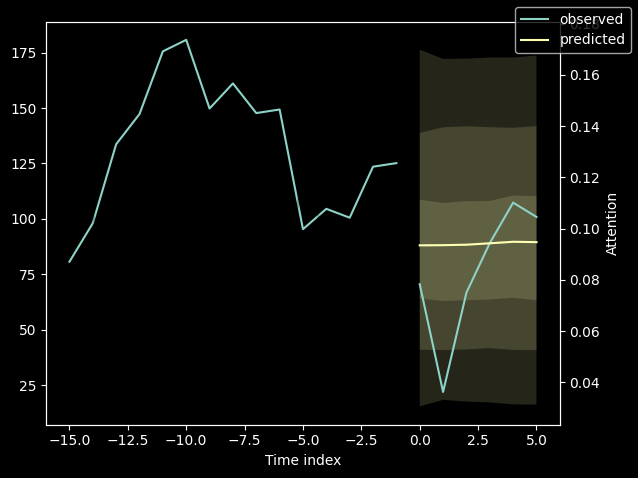

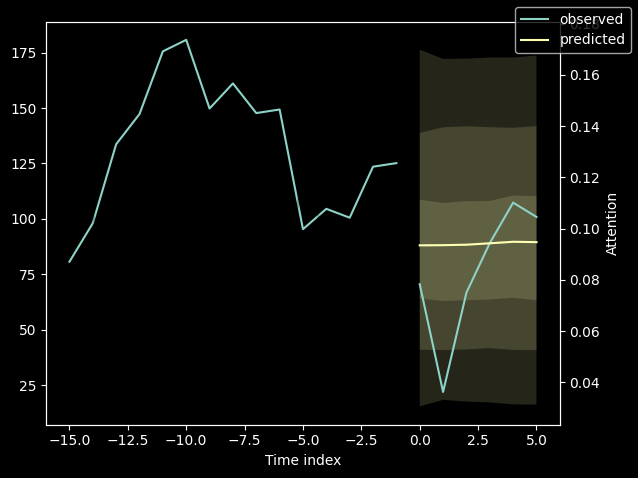

In [18]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

## Predict on new data


Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.


In [19]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [
        last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i))
        for i in range(1, max_prediction_length + 1)
    ],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (
    decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
)
decoder_data["time_idx"] += (
    encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
)

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


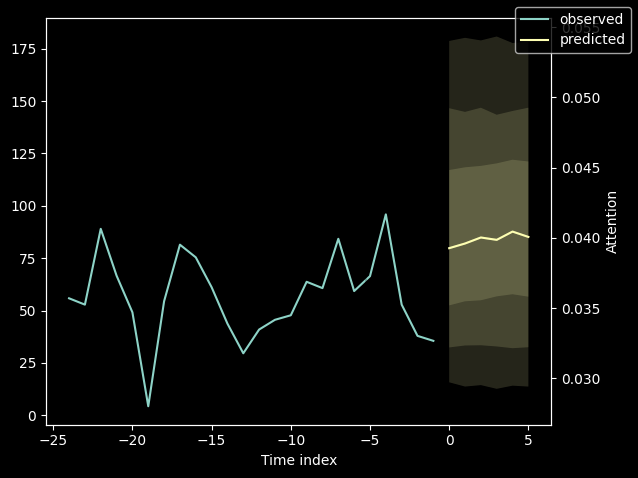

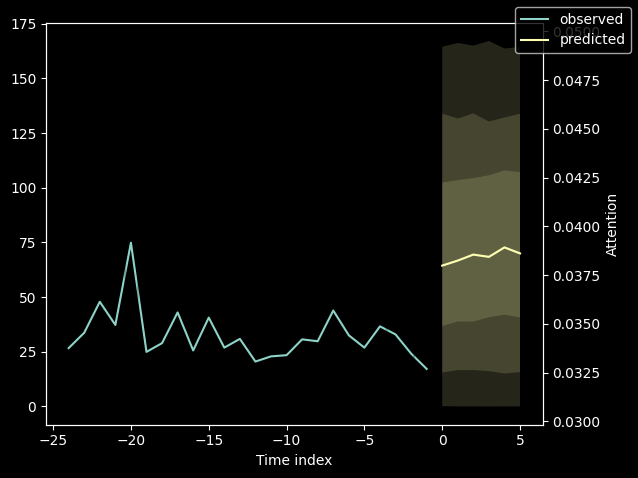

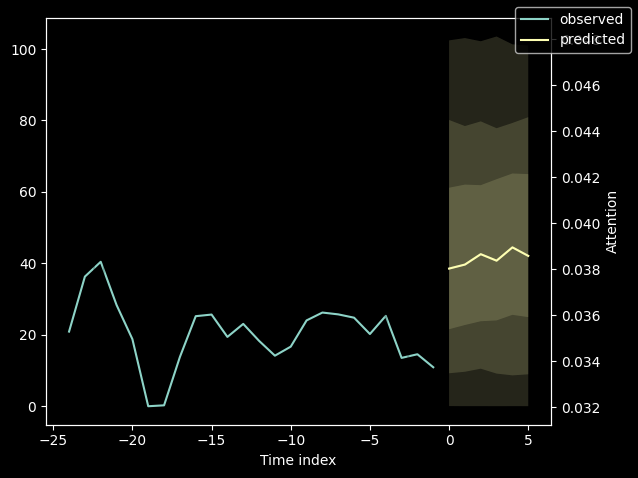

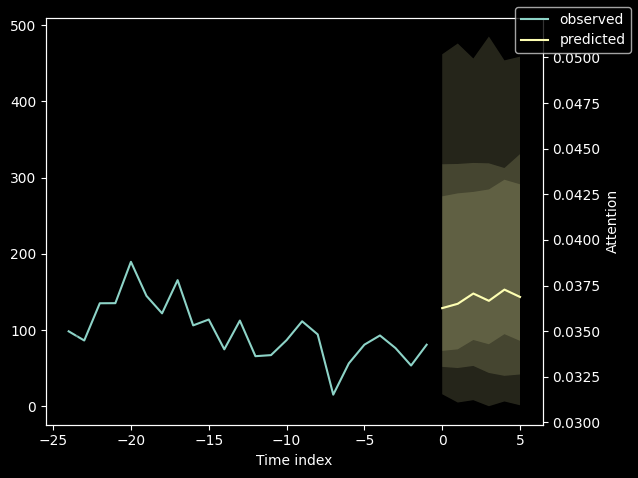

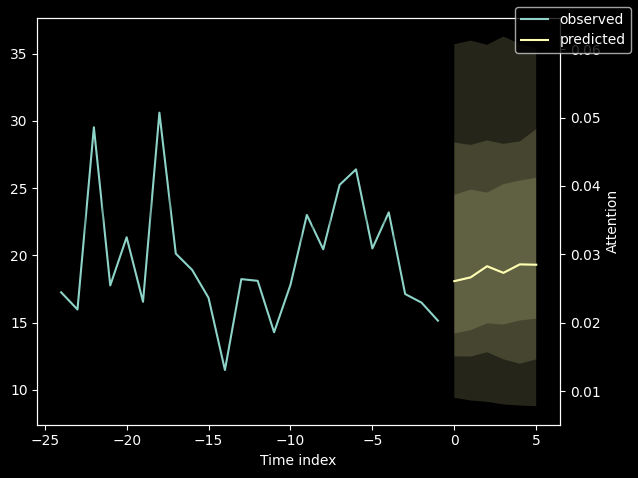

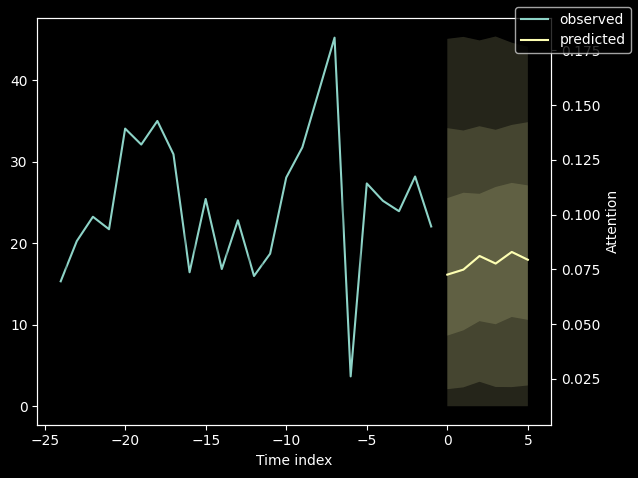

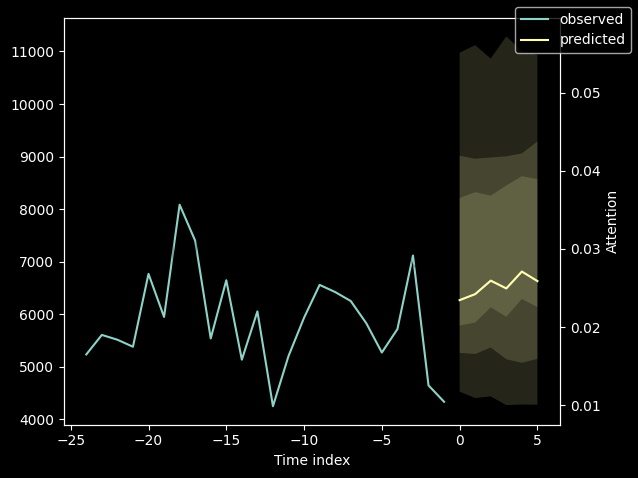

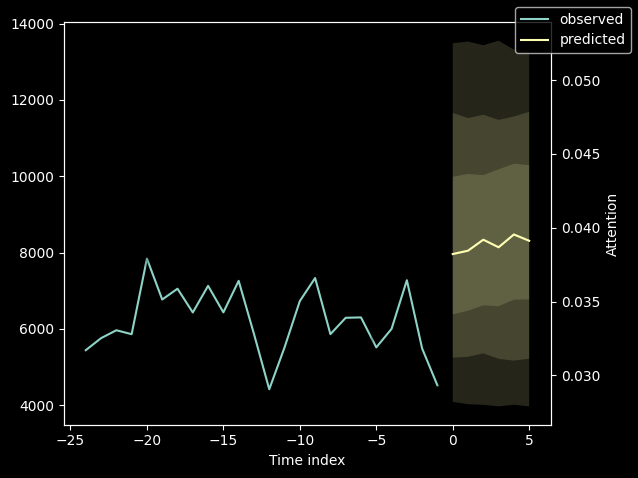

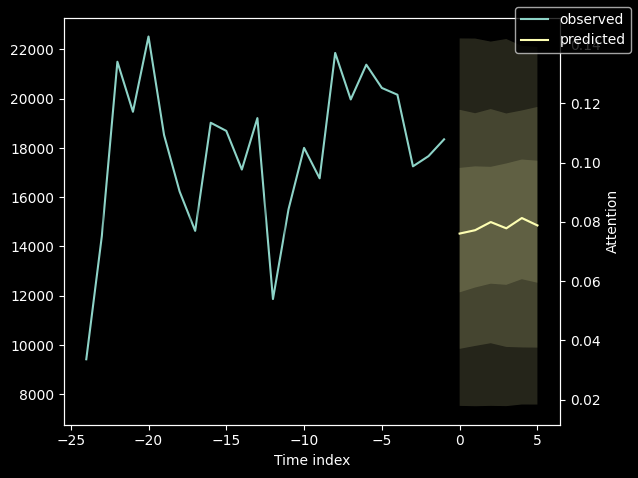

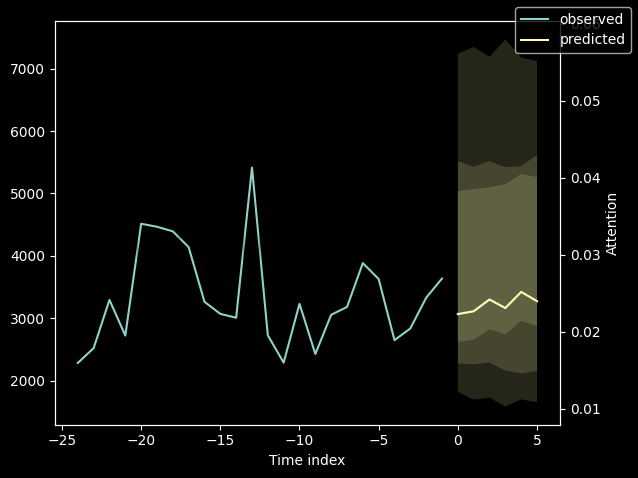

In [20]:
new_raw_predictions = best_tft.predict(
    new_prediction_data,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        new_raw_predictions.x,
        new_raw_predictions.output,
        idx=idx,
        show_future_observed=False,
    )

## Interpret model


### Variable importances


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x525 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

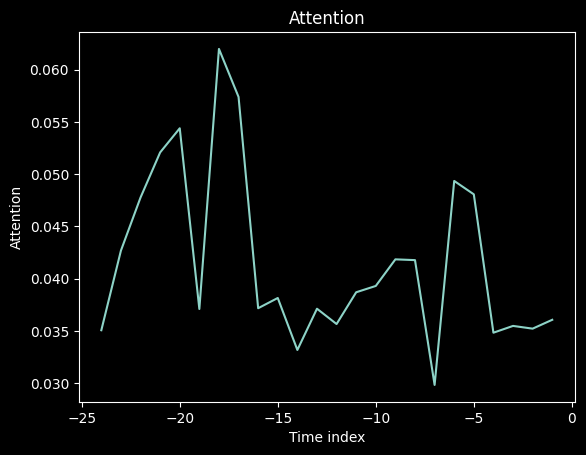

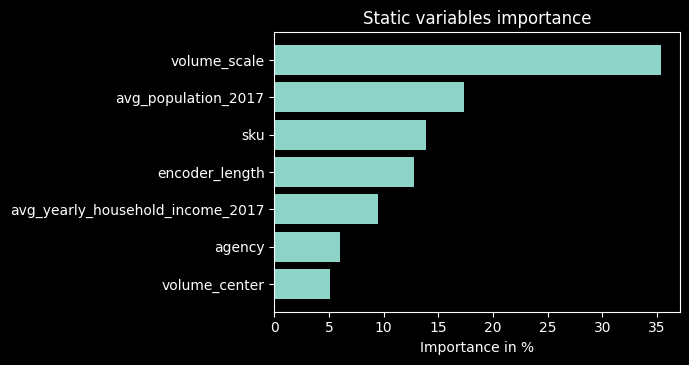

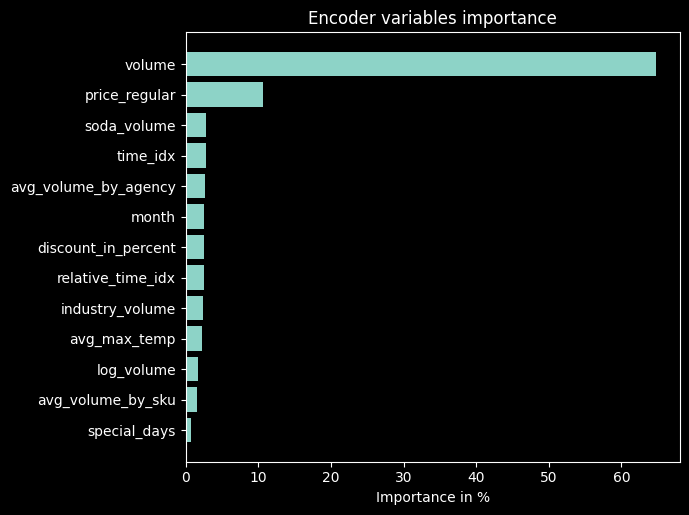

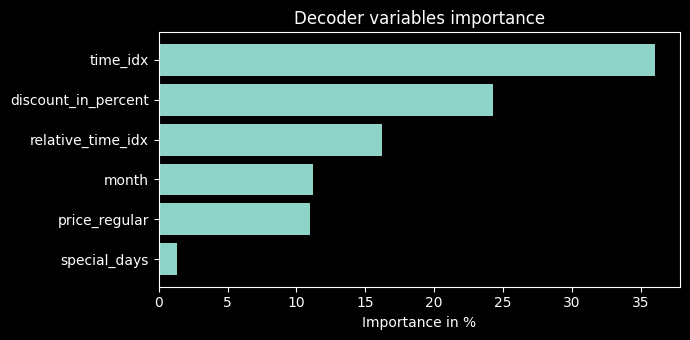

In [21]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.


### Partial dependency


In [22]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset,
    "discount_in_percent",
    np.linspace(0, 30, 30),
    show_progress_bar=True,
    mode="dataframe",
    trainer_kwargs=dict(accelerator="cpu"),
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Predict:   3%|▎         | 1/30 [00:00<00:05,  5.33 batches/s]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Predict:   7%|▋         | 2/30 [00:00<00:05,  5.18 batches/s]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Predict:  10%|█         | 3/30 [00:00<00:04,  5.48 batches/s]You are using the

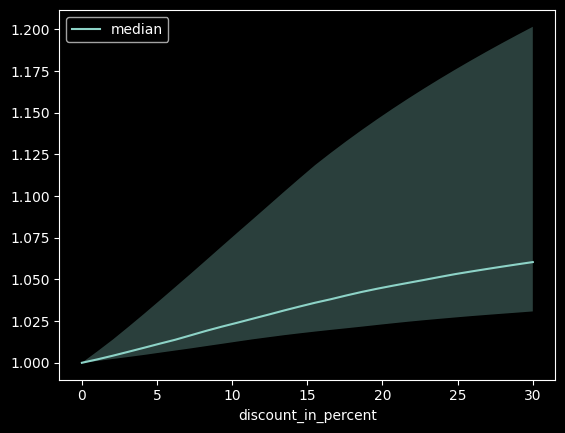

In [23]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)